# Bioinformatics - Single-cell RNA Classification Analysis

Single Cell RNA Analysis. The dataset used describes single-cell mouse tissues. The dataset contains 100,000 cells from the brain of a mouse. Each column in the expression matrix csv file corresponds to a a transcript (gene) wherelese each row corresponds to a single cell. The metadata csv file describes each cell.

In [139]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np

%matplotlib inline

In [140]:
count = pd.read_csv('/content/drive/MyDrive/data/brain_counts.csv', index_col=0)

In [141]:
metadata = pd.read_csv('/content/drive/MyDrive/data/brain_metadata.csv',index_col=0)

In [ ]:
adata = sc.AnnData(X = count, obs = metadata)                           

1.0 Spiked genes

In [95]:
# record and keep count of spikes

is_spiked = {}
num_spikes = 0

for gene in adata.var_names:
    if 'ERCC' in gene:
        is_spiked[gene] = True 
        num_spikes += 1 
    else:
        is_spiked[gene] = False 
        
adata.var['ERCC'] = pd.Series(is_spiked) 

In [64]:
# write
adata.write('/content/drive/MyDrive/data/brain_raw.h5ad')

In [103]:
# read
adata = sc.read('/content/drive/MyDrive/data/brain_raw.h5ad')

2.0 Quality Control

In [104]:
# Compute QC Metrics
qc = sc.pp.calculate_qc_metrics(adata, qc_vars = ['ERCC'])
cell_qc = qc[0]
gene_qc = qc[1]

qc - cells

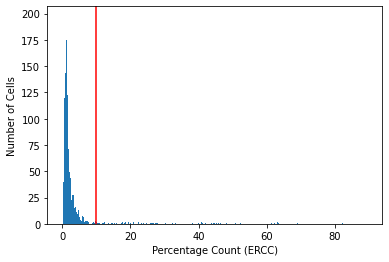

In [105]:
# visualize spike-ins
# outliers to be filtered

plt.hist(cell_qc['pct_counts_ERCC'], bins=1000)
plt.xlabel('Percentage Count (ERCC)')
plt.ylabel('Number of Cells')
plt.axvline(10, color='red')

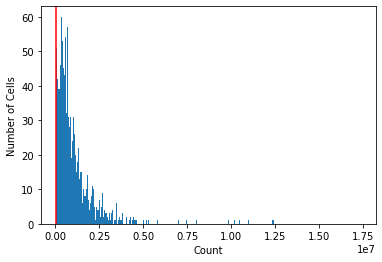

In [106]:
# visualize lib size (reads per cell) 
# cell with few reads to be filtered

plt.hist(cell_qc['total_counts'], bins=1000)
plt.xlabel('Count')
plt.ylabel('Number of Cells')
plt.axvline(50000, color='red')

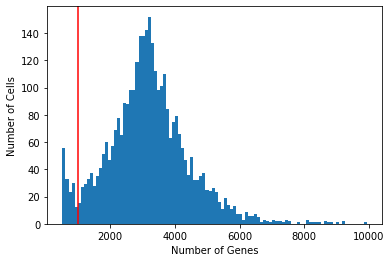

In [107]:
# visualize detected gene-count (in cells)
# outliers to be filtered 

plt.hist(cell_qc['n_genes_by_counts'], bins=100)
plt.xlabel('Number of Genes')
plt.ylabel('Number of Cells')
plt.axvline(1000, color='red')

In [ ]:
# filtering

# by ERCC
low_ERCC = (cell_qc['pct_counts_ERCC'] < 10)
adata = adata[low_ERCC]

# by Gene count
sc.pp.filter_cells(adata, min_genes = 1000)

In [109]:
# write 
adata.write('/content/drive/MyDrive/data/brain_qc.h5ad')

In [110]:
# read
adata = sc.read('/content/drive/MyDrive/data/brain_qc.h5ad')

Cell library normalization

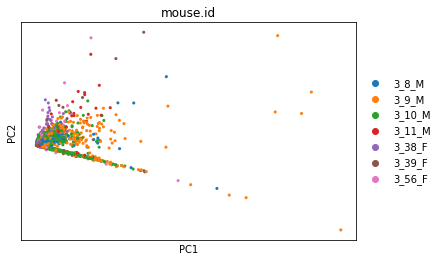

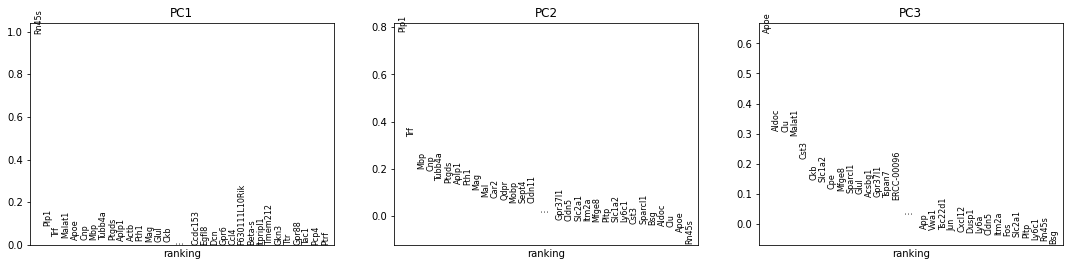

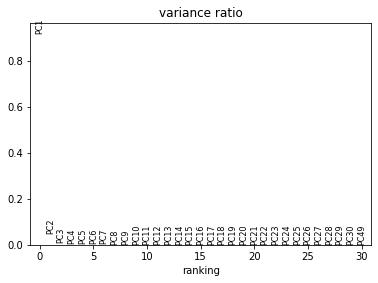

In [112]:
# visualization of data before Normalization

sc.pp.pca(adata)
sc.pl.pca_overview(adata, color='mouse.id')

In [113]:
# copy data. copy and original to be used for comparison
adata_ = adata.copy() 

# copy data before normalizing
adata_.raw = adata_

# CPM normalization
sc.pp.normalize_per_cell(adata_,counts_per_cell_after=1e6)

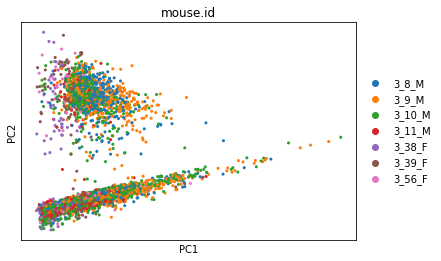

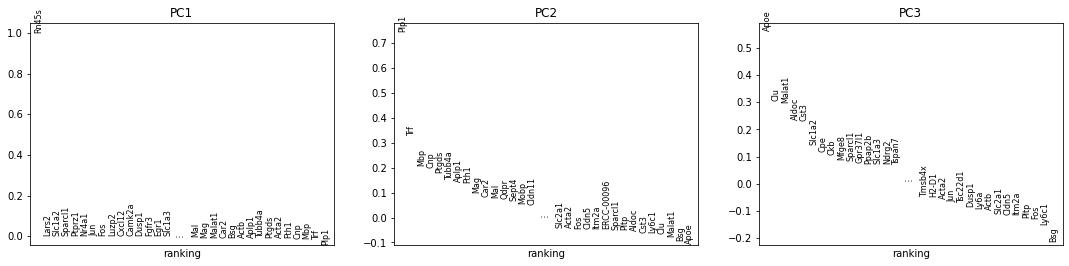

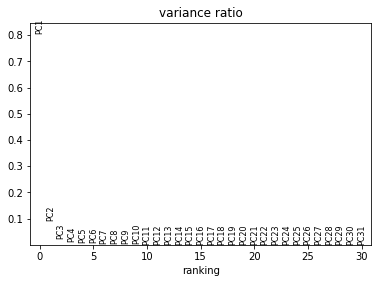

In [114]:
# visualization of data after Normalization

sc.pp.pca(adata_)
sc.pl.pca_overview(adata_, color='mouse.id')

Gene expression normalization

In [117]:
# Rn45s gene is dorminant in data.
# Use normalization to deal with imbalance

Rn45s_0 = adata_.var.index != 'Rn45s'
adata_Rn45s_0 = adata_[:, Rn45s_0]

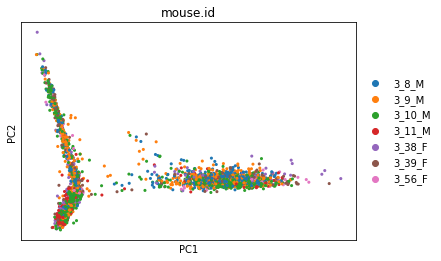

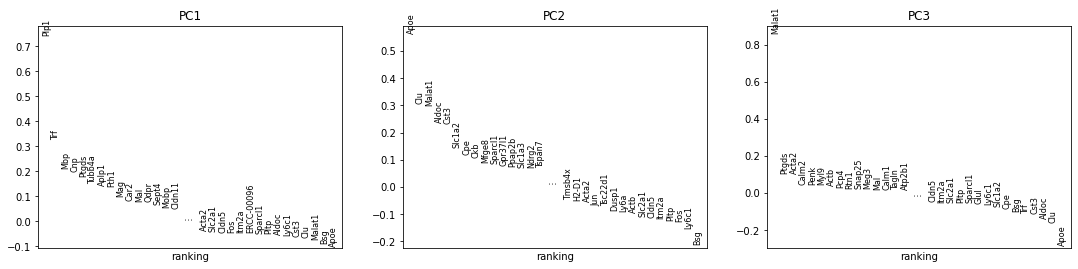

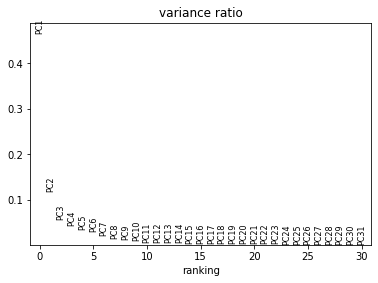

In [118]:
# visualization of data after Normalization

sc.pp.pca(adata_Rn45s_0)
sc.pl.pca_overview(adata_Rn45s_0, color='mouse.id')

In [119]:
# centering and scaling gene expression data

sc.pp.log1p(adata_)
sc.pp.scale(adata_)

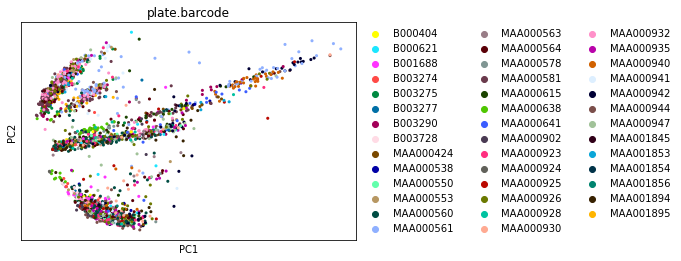

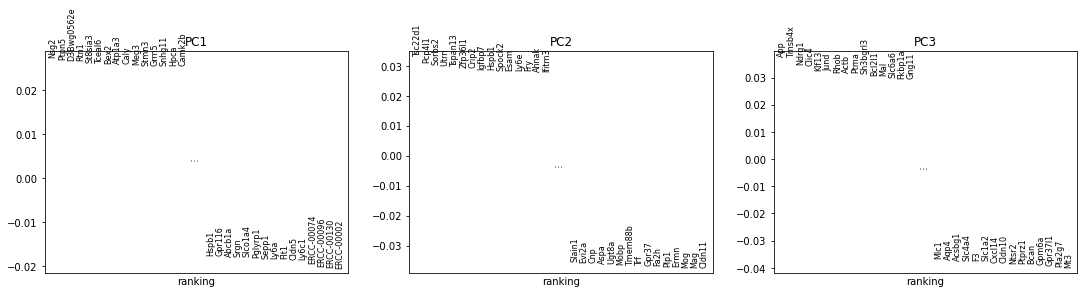

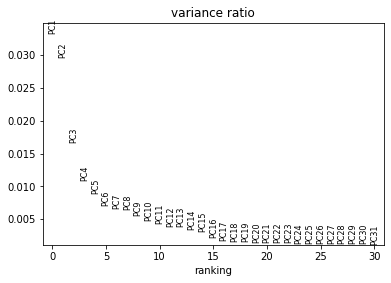

In [120]:
# visualization after Normalization

sc.pp.pca(adata_)
sc.pl.pca_overview(adata_, color='plate.barcode')

In [121]:
# write
adata_.write('/content/drive/MyDrive/data/brain_normalized.h5ad')

In [122]:
# read
adata = sc.read('/content/drive/MyDrive/data/brain_normalized.h5ad')

Dimensionality Reduction - UMAP

In [130]:
sc.pp.neighbors(adata) 
sc.tl.umap(adata, min_dist=0.5, spread=1.0, n_components=2)

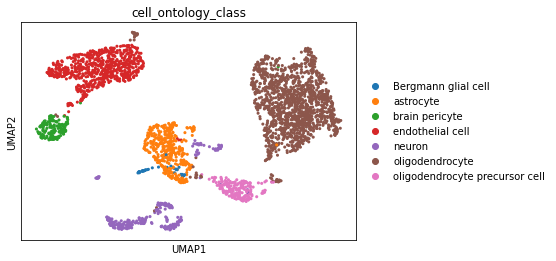

In [131]:
# UMAP visualization using Dimensionality Reduction
sc.pl.umap(adata, color='cell_ontology_class')

Clustering - UMAP

In [134]:
umap_= adata.obsm['X_umap']
kmeans = KMeans(n_clusters=4).fit(umap_)

In [135]:
adata.obs['K Means Clustering'] = kmeans.labels_
adata.obs['K Means Clustering'] = adata.obs['K Means Clustering'].astype(str)

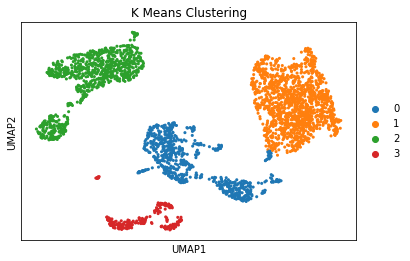

In [137]:
# UMAP visualization using KMeans Clsutering 
sc.pl.umap(adata, color='K Means Clustering')